In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cv1-dataset/test-labels
/kaggle/input/cv1-dataset/test-images
/kaggle/input/cv1-dataset/train-labels
/kaggle/input/cv1-dataset/train.csv
/kaggle/input/cv1-dataset/test.csv
/kaggle/input/cv1-dataset/train-images


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import functional as TF
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import wandb
from skimage.feature import canny, hog
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
import cv2


In [2]:
def load_train_test():
    train_data = pd.read_csv('/kaggle/input/cv1-dataset/train.csv')
    test_data = pd.read_csv('/kaggle/input/cv1-dataset/test.csv')

    X_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28)
    y_train = train_data.iloc[:, 0].values

    X_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28)
    y_test = test_data.iloc[:, 0].values

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train shape: (48000, 28, 28)
y_train shape: [7 8 5 2 3 6 9 4 5]


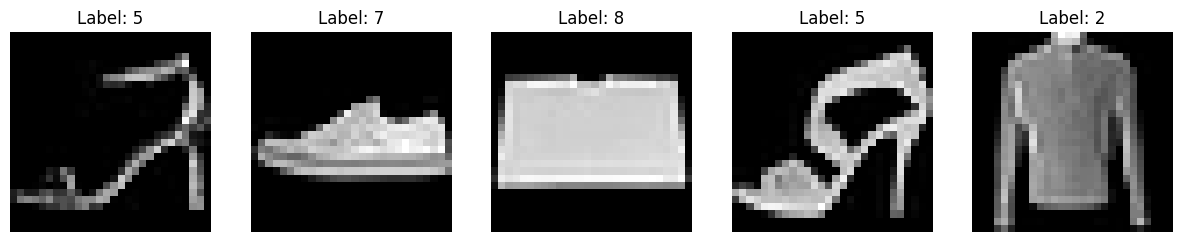

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_train_test()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train[1:10]}")

# Visualize examples
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.show()

In [4]:
unique_labels = np.unique(y_train)

print("Unique labels:", unique_labels)

Unique labels: [0 1 2 3 4 5 6 7 8 9]


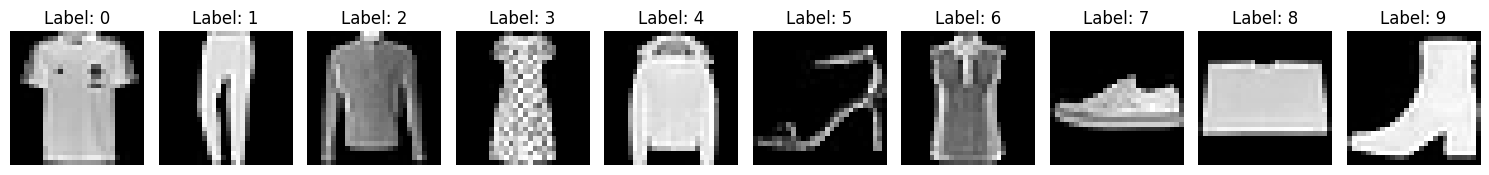

In [5]:
# Create a dictionary to store one image for each label
label_to_image = {}

# Iterate over the dataset to find one image per label
for label in unique_labels:
    index = np.where(y_train == label)[0][0]  # Get the index of the first occurrence of the label
    label_to_image[label] = X_train[index]   # Store the image corresponding to the label

# Plot one image for each unique label
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
for i, label in enumerate(unique_labels):
    axes[i].imshow(label_to_image[label], cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Clothing Types:

    0. T-shirt
    1. Trouser
    2. Pullover
    3. Dress
    4. Coat
    5. Sandal
    6. Shirt
    7. Sneaker
    8. Bag
    9. Ankle Boot


Model Implementation and Training (25 Marks)

1. Train three separate MLP models, each using different input features:

•Model 1: Flattened raw images (1D vector) without any additional
preprocessing.

•Model 2: Edge-detection features using techniques like Canny fea-
tures.

•Model 3: Another transformation, such as HOG features or any-
thing else (use your own creativity for feature extraction, limited to
basic image processing features).

2. Each model should be implemented as a simple multi-layer perceptron
(MLP) using the pytorch library, with appropriate layers, activation func-
tions, and dropout (if required). Ensure each model is trained for sufficient
epochs to reach convergence. (10 Marks)

3. Evaluate each model using metrics such as accuracy, precision, recall, F1-
score, and a confusion matrix on the test dataset. Save the metrics for
comparison. Use wandb to (15 Marks)

In [6]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb") 

wandb.login(key=my_secret)

wandb.init(project="mlp-image-features")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: poorvi-c (poorvi-c-iiit-hyderabad). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
def feature_extractors(feature_type='raw'):
    def extract_canny(images):
        canny_features = []
        for img in images:
            img_norm = (img * 255).astype(np.uint8)
            edges = cv2.Canny(img_norm, 100, 200)
            canny_features.append(edges.flatten())
        return np.array(canny_features)
    
    def extract_hog(images):
        hog_features = []
        hog = cv2.HOGDescriptor((28, 28), (14, 14), (7, 7), (7, 7), 9)
        for img in images:
            img_norm = (img * 255).astype(np.uint8)
            features = hog.compute(img_norm)
            hog_features.append(features.flatten())
        return np.array(hog_features)
    
    extractors = {
        'raw': lambda x: x.reshape(x.shape[0], -1),
        'canny': extract_canny,
        'hog': extract_hog
    }
    return extractors[feature_type]

In [15]:
# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers=[128, 64], dropout_rate=0.3):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 10)) 
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [16]:
def visualize_results(X_test, y_test, test_preds, feature_type):
    # Confusion Matrix
    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {feature_type.upper()} Features')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    wandb.log({f"{feature_type}_confusion_matrix": plt})
    plt.close()

    # Misclassified Images
    misclassified_indices = np.where(y_test != test_preds)[0]
    
    # Select up to 25 misclassified images
    num_images = min(25, len(misclassified_indices))
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    
    for i in range(num_images):
        idx = misclassified_indices[i]
        
        # Reshape the image (assumes original 28x28 format)
        img = X_test[idx].reshape(28, 28)
        
        row = i // 5
        col = i % 5
        
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'True: {y_test[idx]}, Pred: {test_preds[idx]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    wandb.log({f"{feature_type}_misclassified_images": plt})
    plt.close()

In [17]:
def train_and_evaluate(config):
    # Load data
    train_data = pd.read_csv('/kaggle/input/cv1-dataset/train.csv')
    test_data = pd.read_csv('/kaggle/input/cv1-dataset/test.csv')
    
    # Prepare data
    X_train = train_data.iloc[:, 1:].values.reshape(-1, 28, 28) / 255.0
    y_train = train_data.iloc[:, 0].values
    X_test = test_data.iloc[:, 1:].values.reshape(-1, 28, 28) / 255.0
    y_test = test_data.iloc[:, 0].values
    
    # Split validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Feature extraction
    extract_func = feature_extractors(config['feature_type'])
    X_train_features = extract_func(X_train)
    X_val_features = extract_func(X_val)
    X_test_features = extract_func(X_test)
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_features, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_features, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_features, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Model
    model = MLP(
        input_size=X_train_features.shape[1],
        hidden_layers=eval(config['hidden_layers']),
        dropout_rate=config['dropout']
    )
    
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Training Loop
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_accuracy = torch.sum(val_preds == y_val_tensor).item() / len(y_val_tensor)
            
            wandb.log({
                "epoch": epoch,
                "train_loss": loss.item(),
                "val_accuracy": val_accuracy
            })
    
    # Test Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_preds = torch.argmax(test_outputs, dim=1)
        
        # Compute Metrics
        accuracy = accuracy_score(y_test, test_preds.numpy())
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, test_preds.numpy(), average='weighted'
        )
        
        visualize_results(
            X_test.reshape(-1, 28, 28), 
            y_test, 
            test_preds.numpy(), 
            config['feature_type']
        )
        
        # Log test metrics
        wandb.log({
            "test_accuracy": accuracy,
            "test_precision": precision,
            "test_recall": recall,
            "test_f1_score": f1
        })
    
    # Finish the wandb run
    wandb.finish()


In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = load_train_test()

In [21]:
# Configurations for 9 runs
configurations = [
    {
        'learning_rate': 0.001,
        'hidden_layers': '[64]',
        'dropout': 0.2,
        'feature_type': 'raw'
    },
    {
        'learning_rate': 0.0001,
        'hidden_layers': '[128, 64]',
        'dropout': 0.3,
        'feature_type': 'canny'
    },
    {
        'learning_rate': 0.01,
        'hidden_layers': '[256, 128, 64]',
        'dropout': 0.4,
        'feature_type': 'hog'
    },
    {
        'learning_rate': 0.001,
        'hidden_layers': '[128, 64]',
        'dropout': 0.3,
        'feature_type': 'raw'
    },
    {
        'learning_rate': 0.0001,
        'hidden_layers': '[64]',
        'dropout': 0.4,
        'feature_type': 'hog'
    },
    {
        'learning_rate': 0.01,
        'hidden_layers': '[256, 128, 64]',
        'dropout': 0.2,
        'feature_type': 'canny'
    },
    {
        'learning_rate': 0.001,
        'hidden_layers': '[64]',
        'dropout': 0.4,
        'feature_type': 'canny'
    },
    {
        'learning_rate': 0.0001,
        'hidden_layers': '[128, 64]',
        'dropout': 0.2,
        'feature_type': 'hog'
    },
    {
        'learning_rate': 0.01,
        'hidden_layers': '[256, 128, 64]',
        'dropout': 0.3,
        'feature_type': 'raw'
    }
]

In [22]:
# Login to wandb
wandb.login()

# Run experiments
for i, config_dict in enumerate(configurations, 1):
    # Create a run name from the parameters
    run_name = f"Run_{i}_LR{config_dict['learning_rate']}_Layers{config_dict['hidden_layers']}_Drop{config_dict['dropout']}_Feature{config_dict['feature_type']}"
    
    # Initialize wandb for each run
    wandb.init(
        project="mlp-feature-runs", 
        config=config_dict,
        name=run_name
    )
    
    # Run the experiment
    train_and_evaluate(config_dict)

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,49
test_accuracy,0.8148
test_f1_score,0.80976
test_precision,0.81249


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,███▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▁▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
epoch,49
test_accuracy,0.6209
test_f1_score,0.59176
test_precision,0.64483


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch,49
test_accuracy,0.8703
test_f1_score,0.87181
test_precision,0.87999


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
epoch,49
test_accuracy,0.8217
test_f1_score,0.81325
test_precision,0.821


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,███▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
epoch,49
test_accuracy,0.589
test_f1_score,0.55873
test_precision,0.58333


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████████████████
epoch,49
test_accuracy,0.8546
test_f1_score,0.85223
test_precision,0.8531


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████
epoch,49
test_accuracy,0.796
test_f1_score,0.79365
test_precision,0.7937


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▅▅▆▇▇▇███
epoch,49
test_accuracy,0.6285
test_f1_score,0.59743
test_precision,0.71207


/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch,49
test_accuracy,0.8573
test_f1_score,0.85544
test_precision,0.85598


In [18]:
data = {
    "Feature Extraction": ["Raw", "Canny", "Hog"],
    "Best Model": [
        "Run_9_LR0.01_Layers[256, 128, 64]_Drop0.3",
        "Run_6_LR0.01_Layers[256, 128, 64]_Drop0.2",
        "Run_3_LR0.01_Layers[256, 128, 64]_Drop0.4"
    ],
    "Layers": ["[256, 128, 64]", "[256, 128, 64]", "[256, 128, 64]"],
    "Dropout": [0.3, 0.2, 0.4],
    "Learning Rate": [0.01, 0.01, 0.01],
    "Test Accuracy": [0.8573, 0.8546, 0.8703],
    "Test Precision": [0.85598, 0.8531, 0.87999],
    "Test Recall": [0.8573, 0.8546, 0.8703],
    "Test F1-Score": [0.85544, 0.85223, 0.87181]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
print("Summary of Performance Metrics for the Best Models:")
display(df)

Summary of Performance Metrics for the Best Models:


,Feature Extraction,Best Model,Layers,Dropout,Learning Rate,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,Raw,"Run_9_LR0.01_Layers[256, 128, 64]_Drop0.3","[256, 128, 64]",0.3,0.01,0.8573,0.85598,0.8573,0.85544
1,Canny,"Run_6_LR0.01_Layers[256, 128, 64]_Drop0.2","[256, 128, 64]",0.2,0.01,0.8546,0.85310,0.8546,0.85223
2,Hog,"Run_3_LR0.01_Layers[256, 128, 64]_Drop0.4","[256, 128, 64]",0.4,0.01,0.8703,0.87999,0.8703,0.87181


**Raw**: The raw model performs well with a test accuracy of 85.73%, as it captures detailed and unprocessed features. However, the lack of feature abstraction may hinder its ability to generalize well, slightly lowering precision and recall.

**Canny**: The edge-focused features from the Canny model yield slightly lower accuracy (85.46%) due to reliance on edge strength, which can miss finer or complex details. It is efficient for tasks involving boundaries but struggles with noisy or low-contrast areas, affecting precision.

**HOG**: The HOG model achieves the highest accuracy (87.03%) by capturing gradient-based structured features, which are robust for patterns and object shapes. Its abstraction reduces noise sensitivity and boosts generalization, leading to higher precision and F1-scores.